In [42]:
import nengo
import nengo_spa as spa
import numpy as np
import matplotlib.pyplot as plt
import random

seed=1

class Explicit(nengo.solvers.Solver):
    def __init__(self, value, weights=False):
        super(Explicit, self).__init__(weights=weights)
        self.value = value
            
    def __call__(self, A, Y, rng=None, E=None):
        return self.value, {}
    
# loads a decoder from a file, defaulting to zero if it doesn't exist
class LoadFrom(nengo.solvers.Solver):
    def __init__(self, filename, weights=False):
        super(LoadFrom, self).__init__(weights=weights)
        self.filename = filename
            
    def __call__(self, A, Y, rng=None, E=None):
        if self.weights:
            shape = (A.shape[1], E.shape[1])
        else:
            shape = (A.shape[1], Y.shape[1])
            
        try:
            value = np.load(self.filename)
            assert value.shape == shape
        except IOError:
            value = np.zeros(shape)
        return value, {}

# helper to create the LoadFrom solver and the needed probe and do the saving
class WeightSaver(object):
    def __init__(self, connection, filename, load=False, sample_every=1.0, weights=False):
        assert isinstance(connection.pre, nengo.Ensemble)
        if not filename.endswith('.npy'):
            filename = filename + '.npy'
        self.filename = filename
        if load:
            connection.solver = LoadFrom(self.filename, weights=weights)
        self.probe = nengo.Probe(connection, 'weights', sample_every=sample_every)
        self.connection = connection
    def save(self, sim):
        np.save(self.filename, sim.data[self.probe][-1].T)
        



In [40]:

        
np.random.seed(seed)
random.seed(seed)

model = nengo.Network(seed=seed)
with model:
    stim = nengo.Node(lambda t: np.sin(t*np.pi*2))
    a = nengo.Ensemble(100, 1)
    b = nengo.Ensemble(50, 1)
    c = nengo.Connection(a, b, learning_rule_type=nengo.PES(learning_rate=1e-4), function=lambda x: 0)
    
    err = nengo.Ensemble(100,1)
    nengo.Connection(a, err, transform=-1)
    nengo.Connection(b, err)
    nengo.Connection(err, c.learning_rule)
    #nengo.Connection(b, c.learning_rule, transform=1)
    nengo.Connection(stim, a)    
    
    ws = WeightSaver(c, 'my_weights', load=False)   # add this line
    
    p_a = nengo.Probe(a, synapse=.005)
    p_b = nengo.Probe(b, synapse=.005)
    p_err = nengo.Probe(err, synapse=.005)
    p_c = nengo.Probe(c, 'weights', synapse=.005)

sim = nengo.Simulator(model)
sim.run(5)
#ws.save(sim)   # and add this line when you're done

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

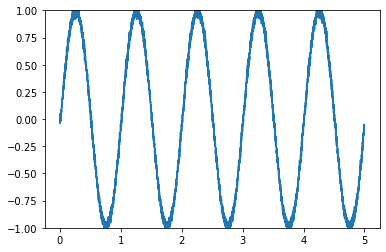

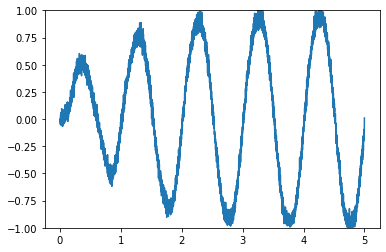

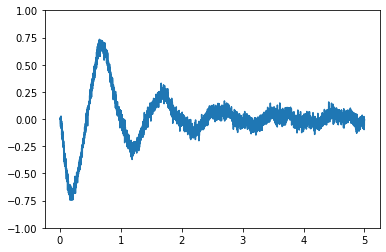

In [41]:
plt.plot(sim.trange(), sim.data[p_a])
plt.ylim(-1,1)
plt.show()

plt.plot(sim.trange(), sim.data[p_b])
plt.ylim(-1,1)
plt.show()

plt.plot(sim.trange(), sim.data[p_err])
plt.ylim(-1,1)
plt.show()